Initializing Kuhn Poker CFR Trainer against StupidBot (Alternating Positions)...
Training CFR for 3000 iterations...
Iteration 1/3000 - Avg Utility: 0.750000, EV vs StupidBot: -0.375000
Iteration 30/3000 - Avg Utility: 1.083333, EV vs StupidBot: -0.662897
Iteration 60/3000 - Avg Utility: 1.297619, EV vs StupidBot: -0.735946
Iteration 90/3000 - Avg Utility: 1.356018, EV vs StupidBot: -0.752512
Iteration 120/3000 - Avg Utility: 1.374167, EV vs StupidBot: -0.782576
Iteration 150/3000 - Avg Utility: 1.379334, EV vs StupidBot: -0.793511
Iteration 180/3000 - Avg Utility: 1.399445, EV vs StupidBot: -0.800389
Iteration 210/3000 - Avg Utility: 1.418572, EV vs StupidBot: -0.803333
Iteration 240/3000 - Avg Utility: 1.441250, EV vs StupidBot: -0.805550
Iteration 270/3000 - Avg Utility: 1.470000, EV vs StupidBot: -0.807356
Iteration 300/3000 - Avg Utility: 1.473000, EV vs StupidBot: -0.810175
Iteration 330/3000 - Avg Utility: 1.487576, EV vs StupidBot: -0.811693
Iteration 360/3000 - Avg Utility: 1.

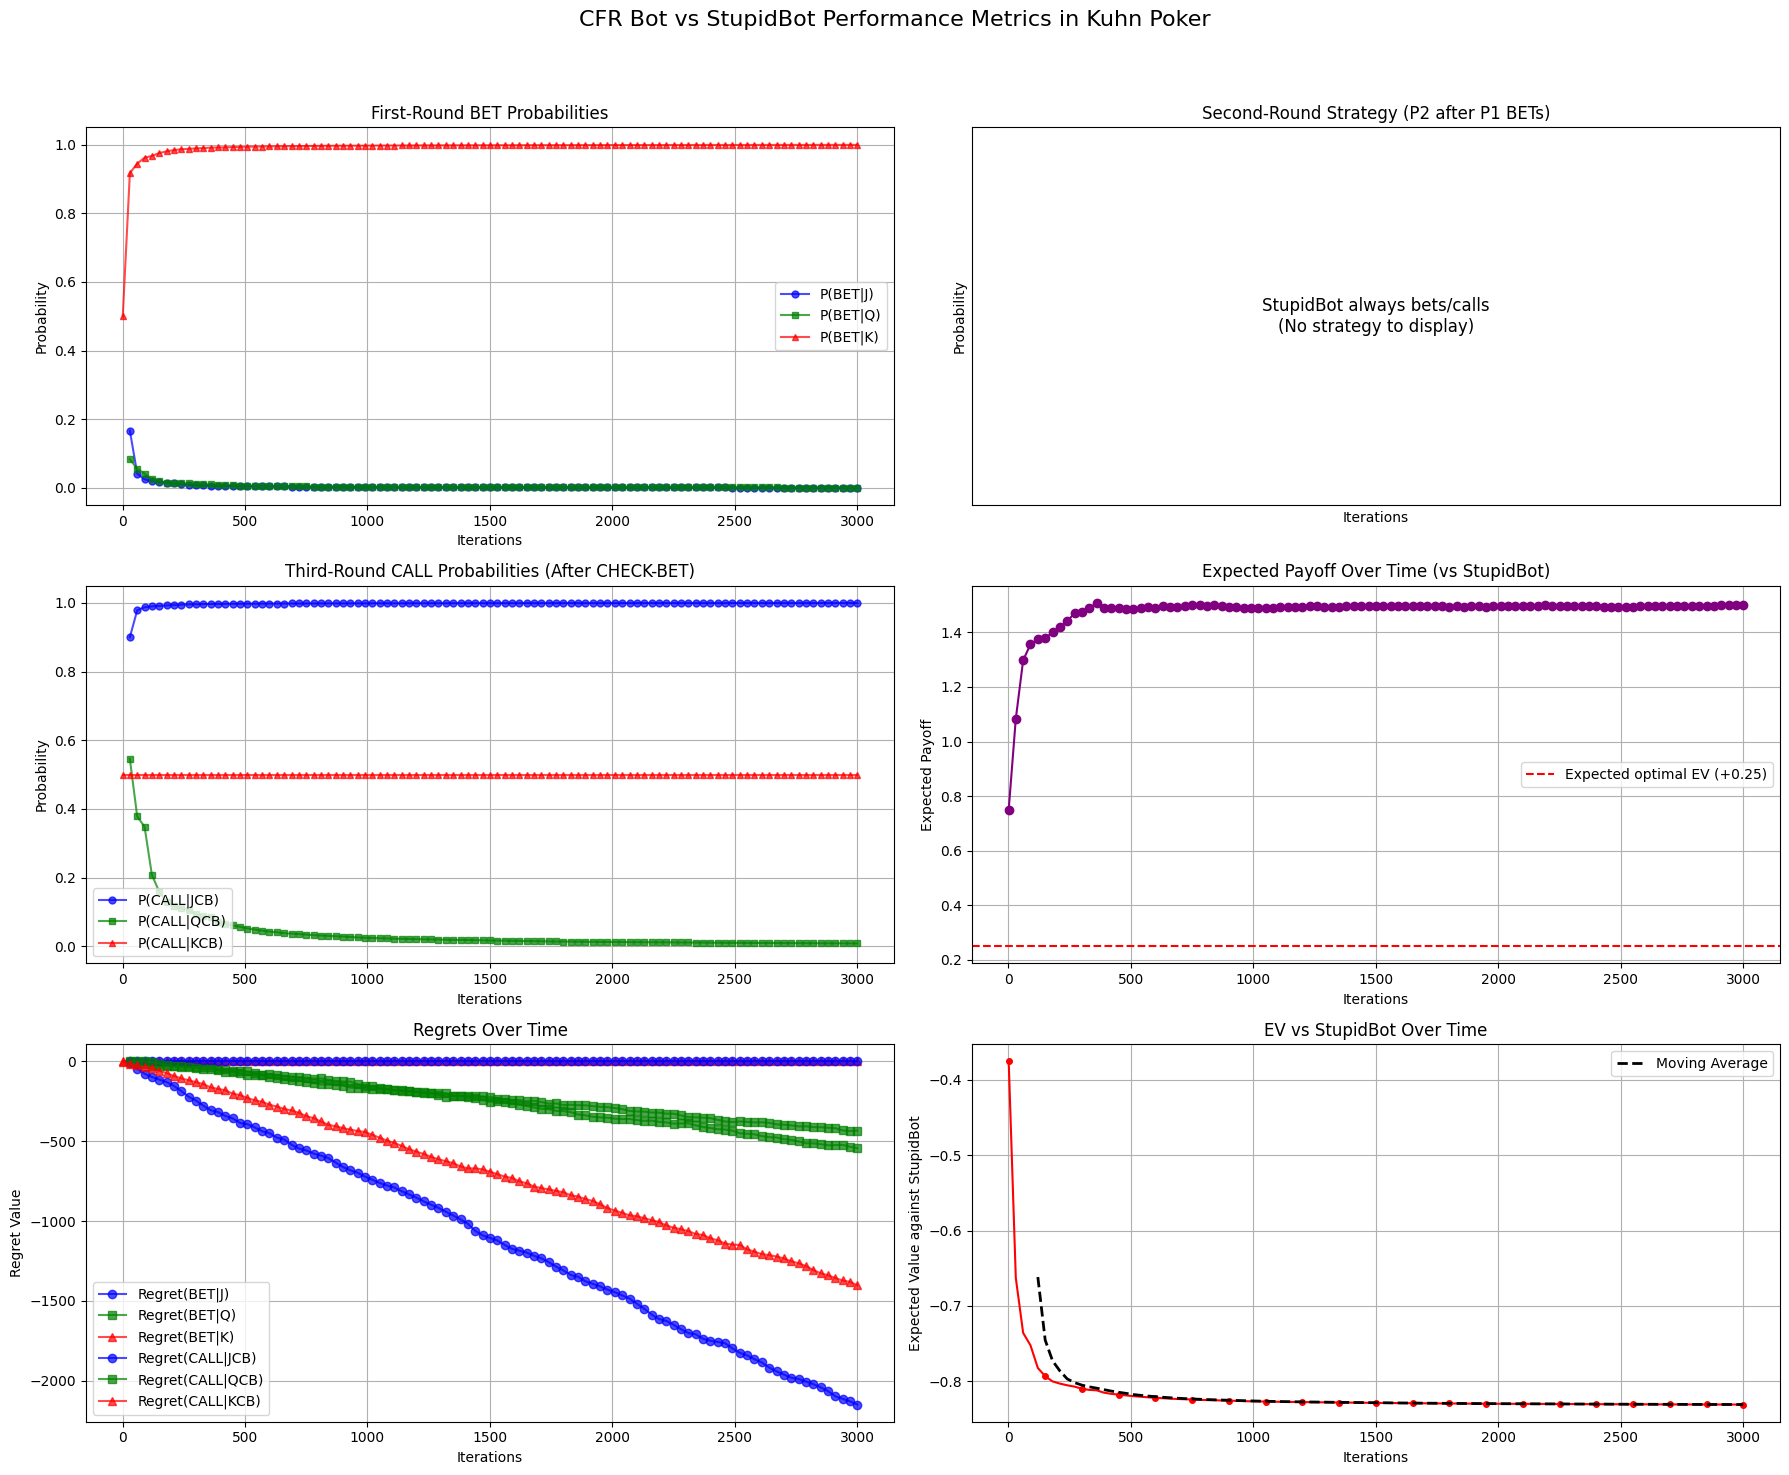

In [56]:
import random
import copy
import matplotlib.pyplot as plt
import numpy as np

# --- Constants ---
# Cards (represented numerically for easy comparison)
JACK = 0
QUEEN = 1
KING = 2
CARDS = [JACK, QUEEN, KING]

# Actions 
CHECK = "CHECK"
BET = "BET"
CALL = "CALL"
FOLD = "FOLD"
ACTIONS = [CHECK, BET, CALL, FOLD]

# Player IDs
PLAYER_1 = 0
PLAYER_2 = 1

class Kuhn_Poker_Game:
    """
    Represents the state and logic of a Kuhn Poker game.
    """
    def __init__(self):
        self.deck = list(CARDS)
        self.player_hands = [None, None] # Player 1's card, Player 2's card
        self.pot = 0
        self.current_player = PLAYER_1
        self.action_history = [] # Sequence of actions taken
        self.is_terminal = False
        self.rewards = {PLAYER_1: 0, PLAYER_2: 0}
        self.reset() # Initialize the first hand

    def reset(self):
        """Resets the game for a new hand."""
        self.deck = list(CARDS)
        random.shuffle(self.deck)

        self.player_hands[PLAYER_1] = self.deck.pop()
        self.player_hands[PLAYER_2] = self.deck.pop()

        # Ante
        self.pot = 2 # Each player puts 1 chip
        self.rewards = {PLAYER_1: -1, PLAYER_2: -1} # Initial investment

        self.current_player = PLAYER_1
        self.action_history = []
        self.is_terminal = False
        
    def reset_with_cards(self, p1_card, p2_card):
        """Resets the game with specific cards for testing."""
        self.player_hands = [p1_card, p2_card]
        self.pot = 2  # Each player puts 1 chip
        self.rewards = {PLAYER_1: -1, PLAYER_2: -1}
        self.current_player = PLAYER_1
        self.action_history = []
        self.is_terminal = False

    def get_current_player(self):
        return self.current_player

    def _card_to_str(self, card):
        if card == JACK: return "J"
        if card == QUEEN: return "Q"
        if card == KING: return "K"
        return "?"

    def get_action_history_str(self):
        """Returns a string representation of the action history."""
        return "".join([a[0] for a in self.action_history]) # e.g., "CB", "B", "CC", "BC"

    def get_legal_actions(self):
        """Returns a list of legal actions for the current player."""
        if self.is_terminal:
            return []

        history_len = len(self.action_history)

        if history_len == 0: # Player 1's first action
            return [CHECK, BET]
        elif history_len == 1: # Player 2's action
            last_action = self.action_history[0]
            if last_action == CHECK:
                return [CHECK, BET]
            else: # Player 1 Bet
                return [CALL, FOLD]
        elif history_len == 2: # Player 1's second action (only if P1 checked, P2 bet)
             # Ensure the sequence is Check, Bet
            if self.action_history[0] == CHECK and self.action_history[1] == BET:
                 return [CALL, FOLD]
            else:
                return []
        else: # Game should have ended
            return []

    def step(self, action):
        """
        Performs an action for the current player, updates the state,
        and determines rewards if the game ends.
        """
        if self.is_terminal:
            raise ValueError("Cannot take action in a terminal state.")

        legal_actions = self.get_legal_actions()
        if action not in legal_actions:
            raise ValueError(f"Illegal action '{action}' for player {self.current_player + 1}. Legal: {legal_actions}. History: {self.action_history}")

        player = self.current_player
        self.action_history.append(action)

        # Update pot based on action
        if action == BET:
            self.pot += 1
            self.rewards[player] -= 1 # Player contributes 1 more chip
            self.current_player = 1 - player # Switch player
        elif action == CALL:
            self.pot += 1
            self.rewards[player] -= 1 # Player contributes 1 more chip
            self.is_terminal = True # Call always ends the betting round -> Showdown
            self._resolve_showdown()
        elif action == FOLD:
            self.is_terminal = True
            winner = 1 - player # The player who didn't fold wins
            loser = player
            winner_reward = self.pot + self.rewards[winner]
            loser_reward = self.rewards[loser]
            self.rewards[winner] = winner_reward
            self.rewards[loser] = loser_reward

        elif action == CHECK:
            # If Player 1 checks, turn passes to Player 2
            # If Player 2 checks after Player 1 checks, game ends (showdown)
            if len(self.action_history) == 2 and self.action_history[0] == CHECK and self.action_history[1] == CHECK:
                self.is_terminal = True
                self._resolve_showdown()
            else:
                # Just pass the turn
                self.current_player = 1 - player

    def _resolve_showdown(self):
        """Compares hands and assigns rewards when a showdown occurs."""
        p1_card = self.player_hands[PLAYER_1]
        p2_card = self.player_hands[PLAYER_2]

        if p1_card > p2_card:
            winner = PLAYER_1
            loser = PLAYER_2
        else: # p2_card > p1_card (no ties in Kuhn)
            winner = PLAYER_2
            loser = PLAYER_1

        winner_reward = self.pot + self.rewards[winner]
        loser_reward = self.rewards[loser]
        self.rewards[winner] = winner_reward
        self.rewards[loser] = loser_reward

    def get_state(self, player):
        """
        Returns the observable state for a given player.
        This is crucial for AI agents as it defines the information set.
        """
        if player < 0 or player > 1:
            raise ValueError("Invalid player index")

        player_card_str = self._card_to_str(self.player_hands[player])
        history_str = self.get_action_history_str()

        return f"{player_card_str}{history_str}"

    def get_rewards(self):
        """Returns the final rewards if the game is terminal."""
        return self.rewards


class StupidBot:
    """
    A simple bot that always bets (calls) regardless of its card
    """
    
    def __init__(self):
        """Initialize the stupid bot"""
        pass
        
    def get_action(self, game):
        """
        Always returns BET action if available, otherwise CALL if available,
        otherwise the first legal action
        """
        legal_actions = game.get_legal_actions()
        if BET in legal_actions:
            return BET
        elif CALL in legal_actions:
            return CALL
        else:
            return legal_actions[0]


class KuhnCFRTrainer:
    """
    Implements the Counterfactual Regret Minimization algorithm for Kuhn Poker.
    Modified to train against StupidBot with alternating first/second player positions.
    """
    def __init__(self, game_instance=None):
        if game_instance is None:
            self.game = Kuhn_Poker_Game()
        else:
            self.game = game_instance

        # Initialize the StupidBot opponent
        self.opponent = StupidBot()
        
        self.node_map = {}
        
        # Metrics for tracking
        self.exploitability_history = []
        self.strategy_history = {}
        self.expected_payoff_history = []
        self.regret_history = {}

    def get_node(self, infoset_key, num_actions, legal_actions):
        """Retrieves or creates a node's data structure in the node map."""
        if infoset_key not in self.node_map:
            self.node_map[infoset_key] = {
                'regret_sum': [0.0] * num_actions,
                'strategy_sum': [0.0] * num_actions,
                'actions': list(legal_actions)
            }
        return self.node_map[infoset_key]

    def get_strategy(self, node_info):
        """
        Calculates the current strategy for an information set using Regret Matching.
        """
        regrets = node_info['regret_sum']
        num_actions = len(node_info['actions'])
        strategy = [0.0] * num_actions

        # Sum of positive regrets only
        positive_regret_sum = sum(max(0, r) for r in regrets)

        if positive_regret_sum > 0:
            # Strategy is proportional to positive regrets
            for i in range(num_actions):
                strategy[i] = max(0, regrets[i]) / positive_regret_sum
        else:
            # If no positive regrets, use a uniform random strategy
            for i in range(num_actions):
                strategy[i] = 1.0 / num_actions
        return strategy

    def _cfr_recursive(self, game_state, reach_p1, reach_p2, cfr_player, opponent_player):
        """
        The core recursive function for CFR traversal.
        Modified to handle any player as the CFR player or opponent.
        
        Args:
            game_state: Current game state
            reach_p1, reach_p2: Reach probabilities
            cfr_player: The player using CFR (0 or 1)
            opponent_player: The player using StupidBot strategy (0 or 1)
        """
        # Base case: If the game state is terminal, return the utility for the CFR player
        if game_state.is_terminal:
            rewards = game_state.get_rewards()
            return rewards[cfr_player]

        # Identify the current player
        current_player = game_state.get_current_player()
        
        # If it's the opponent's turn, use the StupidBot's strategy
        if current_player == opponent_player:
            # Get StupidBot's action
            action = self.opponent.get_action(game_state)
            
            # Create a deep copy of the game state
            next_game_state = copy.deepcopy(game_state)
            next_game_state.step(action)
            
            # Recursively continue
            return -self._cfr_recursive(next_game_state, reach_p1, reach_p2, cfr_player, opponent_player)
        
        # If it's the CFR player's turn
        infoset_key = game_state.get_state(current_player)
        legal_actions = game_state.get_legal_actions()
        num_actions = len(legal_actions)

        # Retrieve or initialize the node data for this information set
        node_info = self.get_node(infoset_key, num_actions, legal_actions)

        # Calculate the current strategy profile for this node using regret matching
        strategy = self.get_strategy(node_info)

        # --- Update Average Strategy ---
        # Reach probability for the CFR player
        reach_prob_cfr = reach_p1 if current_player == PLAYER_1 else reach_p2
        
        for i in range(num_actions):
            node_info['strategy_sum'][i] += reach_prob_cfr * strategy[i]

        # --- Calculate Action Utilities and Node Utility ---
        action_utilities = [0.0] * num_actions
        node_utility = 0.0

        for i, action in enumerate(legal_actions):
            # Create a deep copy of the game state
            next_game_state = copy.deepcopy(game_state)
            next_game_state.step(action)

            # Update reach probabilities
            if current_player == PLAYER_1:
                action_utilities[i] = -self._cfr_recursive(
                    next_game_state, 
                    reach_p1 * strategy[i], 
                    reach_p2, 
                    cfr_player, 
                    opponent_player
                )
            else:  # current_player == PLAYER_2
                action_utilities[i] = -self._cfr_recursive(
                    next_game_state, 
                    reach_p1, 
                    reach_p2 * strategy[i], 
                    cfr_player, 
                    opponent_player
                )
            
            # Accumulate the expected utility
            node_utility += strategy[i] * action_utilities[i]

        # --- Calculate and Update Regrets ---
        # Reach probability for the opponent
        reach_prob_opp = reach_p2 if current_player == PLAYER_1 else reach_p1
        
        for i in range(num_actions):
            regret = action_utilities[i] - node_utility
            node_info['regret_sum'][i] += reach_prob_opp * regret

        return node_utility

    def train(self, iterations, snapshot_intervals=None):
        """
        Runs the CFR algorithm for a specified number of iterations,
        alternating which player uses CFR and which uses StupidBot strategy.
        
        Args:
            iterations: The number of times to traverse the game tree.
            snapshot_intervals: List of iterations where to save snapshots of the strategy
        """
        # Accumulates the expected game value from Player 1's perspective over iterations
        total_utility = 0.0
        
        # Default snapshot intervals if none provided
        if snapshot_intervals is None:
            # Take 20 snapshots
            step = max(1, iterations // 20)
            snapshot_intervals = list(range(step, iterations+1, step))
            # Always include the final iteration
            if iterations not in snapshot_intervals:
                snapshot_intervals.append(iterations)
        
        for i in range(iterations):
            # Start each iteration with a fresh, randomly dealt hand
            self.game.reset()
            
            # Alternate which player uses CFR and which uses StupidBot
            # For even iterations, Player 1 uses CFR and Player 2 uses StupidBot
            # For odd iterations, Player 2 uses CFR and Player 1 uses StupidBot
            if i % 2 == 0:
                cfr_player = PLAYER_1
                opponent_player = PLAYER_2
            else:
                cfr_player = PLAYER_2
                opponent_player = PLAYER_1

            # Initiate the recursive CFR traversal
            iteration_utility = self._cfr_recursive(self.game, 1.0, 1.0, cfr_player, opponent_player)
            
            # If Player 2 is the CFR player, negate the utility to get it from Player 1's perspective
            if cfr_player == PLAYER_2:
                iteration_utility = -iteration_utility
                
            total_utility += iteration_utility

            # Record metrics at specified intervals
            if (i + 1) in snapshot_intervals:
                avg_strategy = self.get_average_strategy()
                exploitability = self.calculate_expected_value_vs_stupidbot(avg_strategy)
                
                self.exploitability_history.append({
                    'iteration': i + 1,
                    'exploitability': exploitability
                })
                
                self.expected_payoff_history.append({
                    'iteration': i + 1, 
                    'expected_payoff': total_utility / (i + 1)
                })
                
                # Store strategy snapshots for all relevant infosets
                key_infosets = [
                    'J', 'Q', 'K',                  # First round P1 initial cards
                    'JC', 'QC', 'KC',               # Second round P2 after P1 checks
                    'JB', 'QB', 'KB',               # Second round P2 after P1 bets  
                    'JCB', 'QCB', 'KCB',            # Third round P1 after P1 CHECK, P2 BET
                    'JCC', 'QCC', 'KCC'             # After P1 CHECK, P2 CHECK
                ]
                strategy_snapshot = {}
                
                for infoset in key_infosets:
                    if infoset in avg_strategy:
                        strategy_snapshot[infoset] = {a: p for a, p in avg_strategy[infoset].items()}
                
                self.strategy_history[i + 1] = strategy_snapshot
                
                # Capture regret values for all infosets
                regret_snapshot = {}
                for infoset, node_info in self.node_map.items():
                    if infoset in key_infosets:
                        # Map regret values to their actions for better readability
                        regret_dict = {action: regret for action, regret in zip(node_info['actions'], node_info['regret_sum'])}
                        regret_snapshot[infoset] = regret_dict
                
                self.regret_history[i + 1] = regret_snapshot
                
                # Print progress
                print(f"Iteration {i+1}/{iterations} - Avg Utility: {total_utility / (i + 1):.6f}, EV vs StupidBot: {exploitability:.6f}")

        print(f"\nTraining finished.")
        print(f"Average game value (Player 1 perspective): {total_utility / iterations:.6f} (Expected: +0.25 ~ +0.28)")
        return {
            'exploitability': self.exploitability_history,
            'strategies': self.strategy_history,
            'expected_payoff': self.expected_payoff_history,
            'regret': self.regret_history
        }

    def get_average_strategy(self):
        """
        Calculates the average strategy profile from the accumulated strategy sums.
        """
        average_strategy = {}
        for infoset_key, node_info in self.node_map.items():
            num_actions = len(node_info['actions'])
            strat_sum = node_info['strategy_sum']
            avg_strat_probs = [0.0] * num_actions
            total_sum = sum(strat_sum)

            # Normalize the strategy sum to get probabilities
            if total_sum > 0:
                for i in range(num_actions):
                    avg_strat_probs[i] = strat_sum[i] / total_sum
            else:
                # Default to uniform if never reached
                for i in range(num_actions):
                    avg_strat_probs[i] = 1.0 / num_actions

            # Map probabilities back to action names for better readability
            action_to_prob_map = {action: prob for action, prob in zip(node_info['actions'], avg_strat_probs)}
            average_strategy[infoset_key] = action_to_prob_map

        return average_strategy

    def calculate_expected_value_vs_stupidbot(self, strategy):
        """
        Calculate the expected value of using the given strategy against StupidBot.
        
        This evaluates how well our strategy performs against the StupidBot in both
        first and second player positions.
        """
        # Calculate EV when CFR strategy plays as Player 1 against StupidBot
        ev_as_p1 = self._evaluate_strategy(strategy, PLAYER_1, PLAYER_2)
        
        # Calculate EV when CFR strategy plays as Player 2 against StupidBot
        ev_as_p2 = self._evaluate_strategy(strategy, PLAYER_2, PLAYER_1)
        
        # Average the two expected values
        return (ev_as_p1 + ev_as_p2) / 2
    
    def _evaluate_strategy(self, strategy, strategy_player, opponent_player):
        """
        Evaluate the expected value of a strategy when playing as strategy_player
        against StupidBot as opponent_player.
        """
        total_utility = 0.0
        num_trials = 1000  # Run multiple trials for statistical significance
        
        # For each card the strategy player can have
        for player_card in CARDS:
            for opponent_card in CARDS:
                # Skip if both players have the same card (impossible in a real game)
                if player_card == opponent_card:
                    continue
                
                # Probability of this card arrangement = 1/6 (with 3 cards)
                card_prob = 1.0 / (len(CARDS) * (len(CARDS) - 1))
                
                # Create a game with these specific cards
                game = Kuhn_Poker_Game()
                if strategy_player == PLAYER_1:
                    game.reset_with_cards(player_card, opponent_card)
                else:
                    game.reset_with_cards(opponent_card, player_card)
                
                # Evaluate this specific scenario
                utility = self._evaluate_scenario(game, strategy, strategy_player, opponent_player)
                
                # Weight by probability of this card arrangement
                total_utility += card_prob * utility
        
        return total_utility
    
    def _evaluate_scenario(self, game, strategy, strategy_player, opponent_player):
        """
        Evaluate a specific game scenario.
        """
        if game.is_terminal:
            return game.get_rewards()[strategy_player]
        
        current_player = game.get_current_player()
        
        if current_player == opponent_player:
            # StupidBot's turn
            action = self.opponent.get_action(game)
            
            # Take action and continue
            next_game = copy.deepcopy(game)
            next_game.step(action)
            
            return self._evaluate_scenario(next_game, strategy, strategy_player, opponent_player)
        else:
            # Strategy player's turn
            infoset_key = game.get_state(current_player)
            legal_actions = game.get_legal_actions()
            
            # Get action probabilities from strategy
            if infoset_key in strategy:
                action_probs = strategy[infoset_key]
            else:
                # Default to uniform if not found
                action_probs = {action: 1.0 / len(legal_actions) for action in legal_actions}
            
            # Calculate expected utility for this position
            expected_utility = 0.0
            for action in legal_actions:
                if action in action_probs:
                    prob = action_probs[action]
                    if prob > 0:
                        next_game = copy.deepcopy(game)
                        next_game.step(action)
                        
                        utility = self._evaluate_scenario(next_game, strategy, strategy_player, opponent_player)
                        expected_utility += prob * utility
            
            return expected_utility

    def plot_results(self):
        """
        Create comprehensive plots for the tracked metrics during CFR training.
        """
        # Create a figure with subplots
        fig, axs = plt.subplots(3, 2, figsize=(18, 15))
        fig.suptitle('CFR Bot vs StupidBot Performance Metrics in Kuhn Poker', fontsize=16)
        
        iterations = sorted(self.strategy_history.keys())
        
        # 1. First round BET probabilities
        ax1 = axs[0, 0]
        cards = ['J', 'Q', 'K']
        colors = ['blue', 'green', 'red']
        markers = ['o', 's', '^']
        
        for i, card in enumerate(cards):
            bet_probs = []
            
            for iter_num in iterations:
                if card in self.strategy_history[iter_num]:
                    bet_probs.append(self.strategy_history[iter_num][card].get(BET, 0))
                else:
                    bet_probs.append(None)
            
            ax1.plot(iterations, bet_probs, linestyle='-', color=colors[i], marker=markers[i], markersize=5,
                     alpha=0.7, label=f'P(BET|{card})')
        
        ax1.set_title('First-Round BET Probabilities')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Probability')
        ax1.set_ylim(-0.05, 1.05)
        ax1.legend(loc='best')
        ax1.grid(True)
        
        # 2. Empty plot for Second-Round Strategy
        ax2 = axs[0, 1]
        ax2.text(0.5, 0.5, 'StupidBot always bets/calls\n(No strategy to display)', 
                 horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes,
                 fontsize=12)
        ax2.set_title('Second-Round Strategy (P2 after P1 BETs)')
        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('Probability')
        ax2.set_xticks([])
        ax2.set_yticks([])
        
        # 3. Third-Round CALL Probabilities
        ax3 = axs[1, 0]
        third_round_infosets = ['JCB', 'QCB', 'KCB']
        
        for i, infoset in enumerate(third_round_infosets):
            call_probs = []
            
            for iter_num in iterations:
                if infoset in self.strategy_history[iter_num]:
                    call_probs.append(self.strategy_history[iter_num][infoset].get(CALL, 0))
                else:
                    call_probs.append(None)
            
            ax3.plot(iterations, call_probs, linestyle='-', color=colors[i], marker=markers[i], markersize=5,
                     alpha=0.7, label=f'P(CALL|{infoset})')
        
        ax3.set_title('Third-Round CALL Probabilities (After CHECK-BET)')
        ax3.set_xlabel('Iterations')
        ax3.set_ylabel('Probability')
        ax3.set_ylim(-0.05, 1.05)
        ax3.legend(loc='best')
        ax3.grid(True)
        
        # 4. Expected Payoff
        ax4 = axs[1, 1]
        iterations_payoff = [entry['iteration'] for entry in self.expected_payoff_history]
        payoffs = [entry['expected_payoff'] for entry in self.expected_payoff_history]
        
        ax4.plot(iterations_payoff, payoffs, 'o-', color='purple')
        ax4.axhline(y=0.25, color='r', linestyle='--', label='Expected optimal EV (+0.25)')
        ax4.set_title('Expected Payoff Over Time (vs StupidBot)')
        ax4.set_xlabel('Iterations')
        ax4.set_ylabel('Expected Payoff')
        ax4.legend()
        ax4.grid(True)
        
        # 5. Regrets for key infosets
        ax5 = axs[2, 0]
        infosets_to_plot = [
            ('J', BET), ('Q', BET), ('K', BET),
            ('JCB', CALL), ('QCB', CALL), ('KCB', CALL)
        ]
        
        for i, (infoset, action) in enumerate(infosets_to_plot):
            regrets = []
            for iter_num in iterations:
                if infoset in self.regret_history[iter_num]:
                    regrets.append(self.regret_history[iter_num][infoset].get(action, 0))
                else:
                    regrets.append(None)
            
            color_idx = i % len(colors)
            marker_idx = i % len(markers)
            
            ax5.plot(iterations, regrets, marker=markers[marker_idx], linestyle='-',
                     color=colors[color_idx], alpha=0.7, label=f'Regret({action}|{infoset})')
        
        ax5.set_title('Regrets Over Time')
        ax5.set_xlabel('Iterations')
        ax5.set_ylabel('Regret Value')
        ax5.legend(loc='best')
        ax5.grid(True)
        
        # 6. Performance vs StupidBot
        ax6 = axs[2, 1]
        iterations_exploit = [entry['iteration'] for entry in self.exploitability_history]
        exploitability = [entry['exploitability'] for entry in self.exploitability_history]
        
        ax6.plot(iterations_exploit, exploitability, '-', color='red',
                marker='o', markersize=4, markevery=max(1, len(iterations_exploit)//20))
        
        if len(exploitability) > 5:
            window_size = min(5, len(exploitability) // 10) 
            moving_avg = np.convolve(exploitability, np.ones(window_size)/window_size, mode='valid')
            moving_avg_x = iterations_exploit[window_size-1:]
            ax6.plot(moving_avg_x, moving_avg, 'k--', linewidth=2, label='Moving Average')
            
        ax6.set_title('EV vs StupidBot Over Time')
        ax6.set_xlabel('Iterations')
        ax6.set_ylabel('Expected Value against StupidBot')
        if len(exploitability) > 5:
            ax6.legend()
        ax6.grid(True)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        return fig


# Run the CFR trainer and plot the results
def main():
    print("Initializing Kuhn Poker CFR Trainer against StupidBot (Alternating Positions)...")
    trainer = KuhnCFRTrainer()
    
    # Train for a reasonable number of iterations
    iterations = 3000
    
    # Define even snapshot intervals
    snapshot_points = list(range(0, iterations+1, iterations//100))  # 100 evenly spaced points

    # Always include the first and last iterations
    if 1 not in snapshot_points:
        snapshot_points = [1] + snapshot_points
    if iterations not in snapshot_points:
        snapshot_points.append(iterations)
    snapshot_points.sort()
    
    print(f"Training CFR for {iterations} iterations...")
    results = trainer.train(iterations, snapshot_intervals=snapshot_points)
    
    # Plot the results
    print("Generating plots...")
    fig = trainer.plot_results()
    
    # Save the figure
    output_file = "kuhn_cfr_vs_stupidbot_alternating.png"
    fig.savefig(output_file)
    print(f"Plots saved to {output_file}")
    
    # Print final strategy
    print("\nFinal strategy (optimized against StupidBot):")
    final_strategy = trainer.get_average_strategy()
    
    # Create a more comprehensive display of strategies
    print("\n--- First Round Strategies ---")
    print("Card | Action | Probability")
    print("-" * 30)
    
    key_infosets = ['J', 'Q', 'K']
    for infoset in key_infosets:
        if infoset in final_strategy:
            for action, prob in final_strategy[infoset].items():
                print(f"{infoset:4} | {action:6} | {prob:.4f}")
    
    # Second round strategies after P1 checks
    print("\n--- Second Round Strategies (P2 after P1 checks) ---")
    print("InfoSet | Action | Probability")
    print("-" * 35)
    
    key_infosets2 = ['JC', 'QC', 'KC']
    for infoset in key_infosets2:
        if infoset in final_strategy:
            for action, prob in final_strategy[infoset].items():
                print(f"{infoset:7} | {action:6} | {prob:.4f}")
    
    # Second round strategies after P1 bets
    print("\n--- Second Round Strategies (P2 after P1 bets) ---")
    print("InfoSet | Action | Probability")
    print("-" * 35)
    
    key_infosets3 = ['JB', 'QB', 'KB']
    for infoset in key_infosets3:
        if infoset in final_strategy:
            for action, prob in final_strategy[infoset].items():
                print(f"{infoset:7} | {action:6} | {prob:.4f}")
    
    # Third round strategies after P1 checks, P2 bets
    print("\n--- Third Round Strategies (P1 after CHECK-BET) ---")
    print("InfoSet | Action | Probability")
    print("-" * 35)
    
    key_infosets4 = ['JCB', 'QCB', 'KCB']
    for infoset in key_infosets4:
        if infoset in final_strategy:
            for action, prob in final_strategy[infoset].items():
                print(f"{infoset:7} | {action:6} | {prob:.4f}")
    
    print("\nCFR Trainer execution finished.")

if __name__ == "__main__":
    main()

Initializing Kuhn Poker CFR Trainer...
Training CFR for 5000 iterations...
Iteration 1/5000 - Avg Utility: -0.250000, EV vs StupidBot: -0.375000
Iteration 50/5000 - Avg Utility: 1.305239, EV vs StupidBot: -0.653810
Iteration 100/5000 - Avg Utility: 1.372629, EV vs StupidBot: -0.718272
Iteration 150/5000 - Avg Utility: 1.409478, EV vs StupidBot: -0.741366
Iteration 200/5000 - Avg Utility: 1.430227, EV vs StupidBot: -0.763280
Iteration 250/5000 - Avg Utility: 1.472181, EV vs StupidBot: -0.774500
Iteration 300/5000 - Avg Utility: 1.463484, EV vs StupidBot: -0.787964
Iteration 350/5000 - Avg Utility: 1.482987, EV vs StupidBot: -0.793746
Iteration 400/5000 - Avg Utility: 1.484628, EV vs StupidBot: -0.799549
Iteration 450/5000 - Avg Utility: 1.501892, EV vs StupidBot: -0.802185
Iteration 500/5000 - Avg Utility: 1.507703, EV vs StupidBot: -0.805684
Iteration 550/5000 - Avg Utility: 1.508821, EV vs StupidBot: -0.808490
Iteration 600/5000 - Avg Utility: 1.501419, EV vs StupidBot: -0.811236
Iter

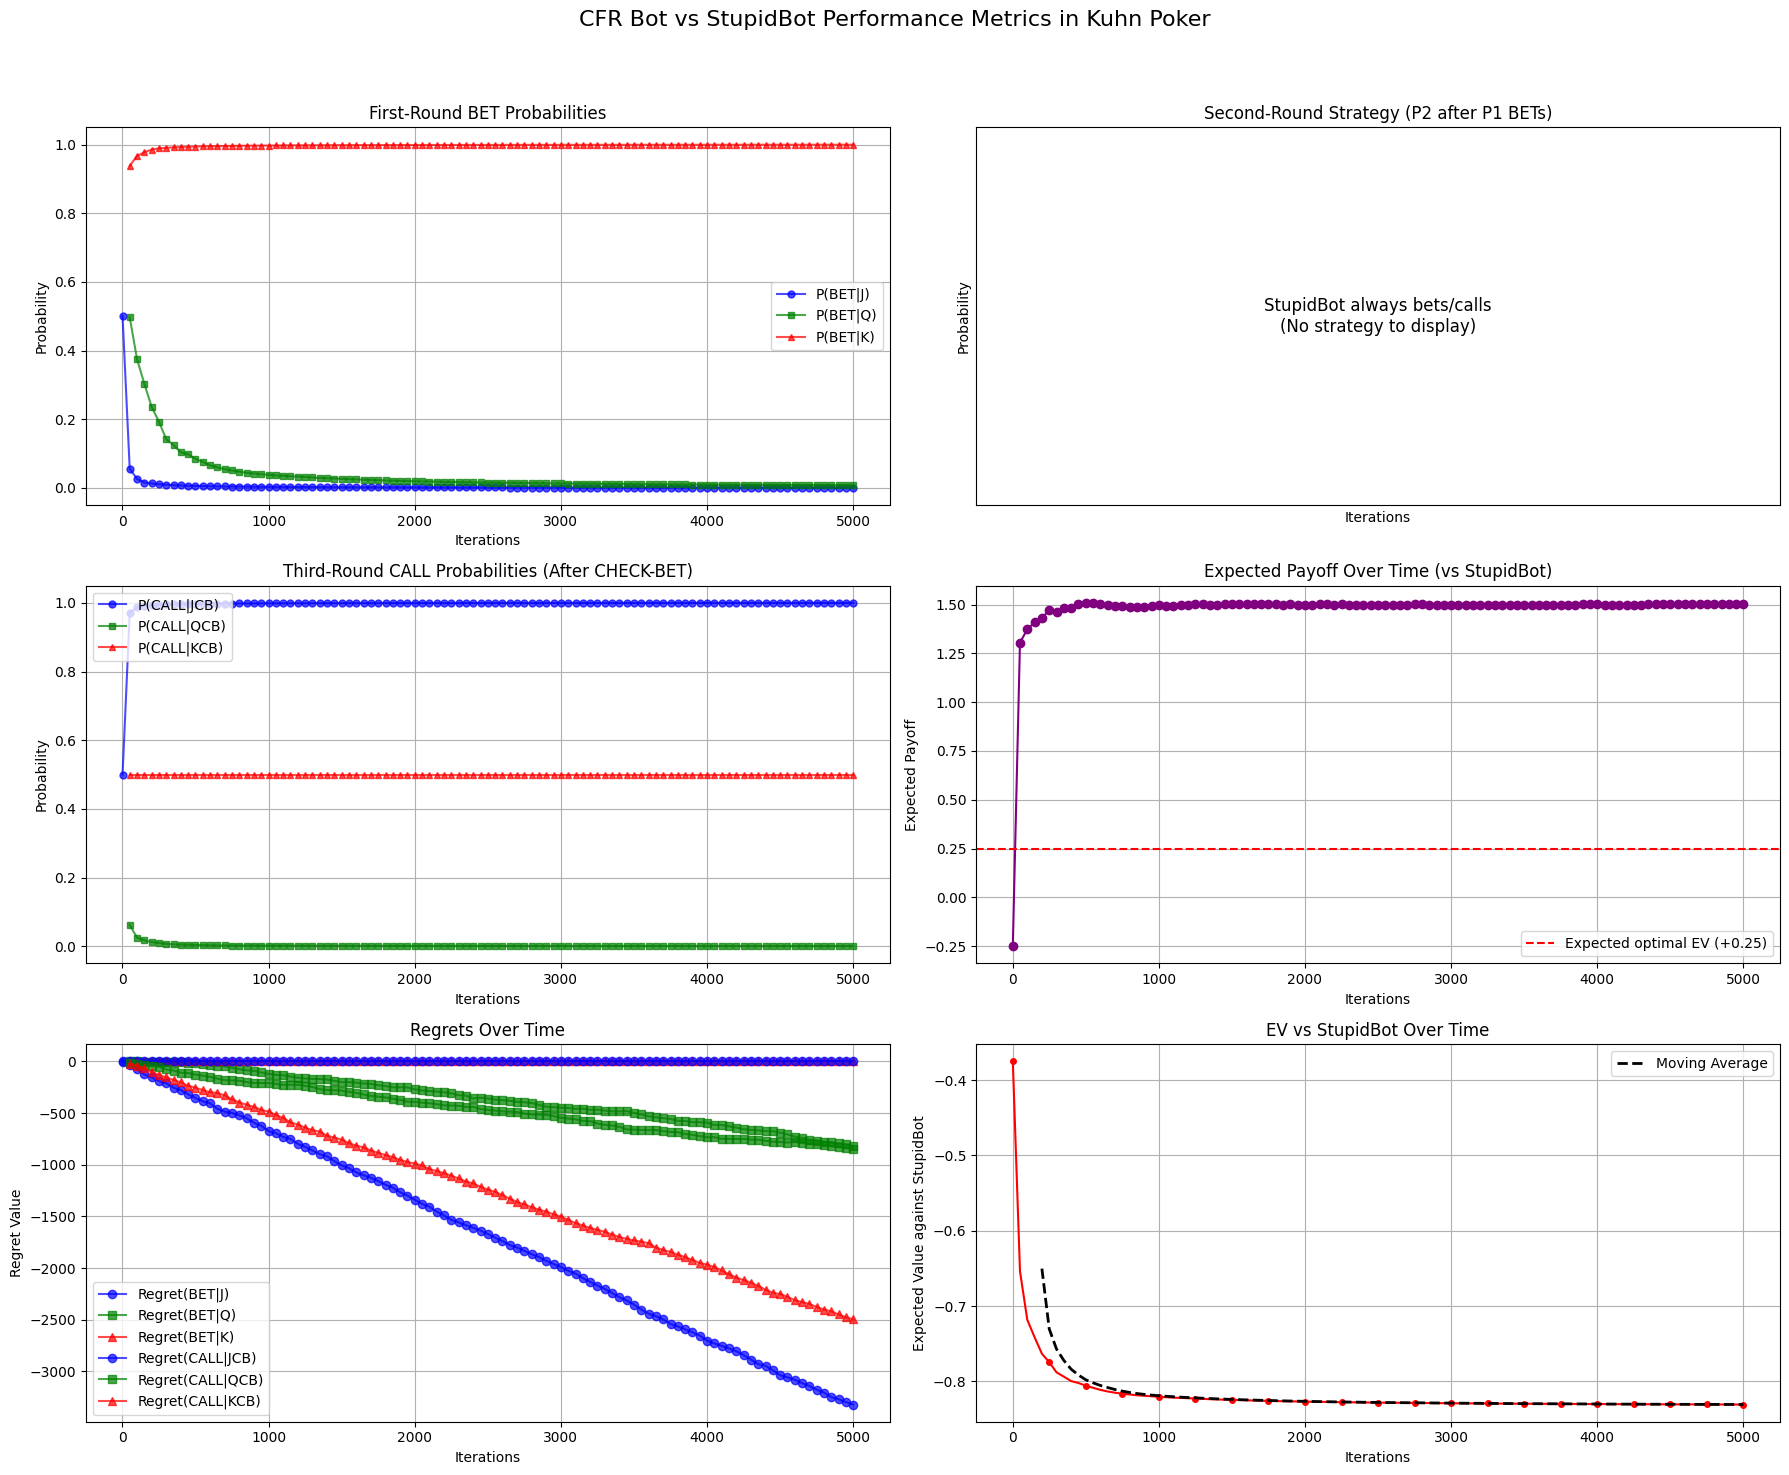

In [57]:
import json
import numpy as np

def extract_and_save_metrics(trainer, filename='metrics_history.json'):
    """
    Extract the strategy and regret data from the CFR trainer and save it
    in the format matching the correct.json structure.
    
    Args:
        trainer: A trained KuhnCFRTrainer instance
        filename: The filename to save the metrics data to
    """
    iterations = sorted(trainer.strategy_history.keys())
    
    metrics_history = {
        "iterations": iterations,
        "first_round_strategies": {
            "J": {
                "BET": []
            },
            "Q": {
                "BET": []
            },
            "K": {
                "BET": []
            }
        },
        "regrets": {
            "J": {
                "BET": []
            },
            "Q": {
                "BET": []
            },
            "K": {
                "CHECK": []
            },
            "JB": {
                "CALL": []
            },
            "QB": {
                "CALL": []
            },
            "KB": {
                "CALL": []
            },
            "JCB": {
                "CALL": []
            },
            "QCB": {
                "CALL": []
            },
            "KCB": {
                "CALL": []
            }
        }
    }
    
    # Fill in the first round strategies data - BET probabilities
    for iter_num in iterations:
        # For J card
        if 'J' in trainer.strategy_history[iter_num]:
            bet_prob_j = trainer.strategy_history[iter_num]['J'].get("BET", 0)
            metrics_history["first_round_strategies"]["J"]["BET"].append(bet_prob_j)
        else:
            metrics_history["first_round_strategies"]["J"]["BET"].append(None)
            
        # For Q card
        if 'Q' in trainer.strategy_history[iter_num]:
            bet_prob_q = trainer.strategy_history[iter_num]['Q'].get("BET", 0)
            metrics_history["first_round_strategies"]["Q"]["BET"].append(bet_prob_q)
        else:
            metrics_history["first_round_strategies"]["Q"]["BET"].append(None)
            
        # For K card
        if 'K' in trainer.strategy_history[iter_num]:
            bet_prob_k = trainer.strategy_history[iter_num]['K'].get("BET", 0)
            metrics_history["first_round_strategies"]["K"]["BET"].append(bet_prob_k)
        else:
            metrics_history["first_round_strategies"]["K"]["BET"].append(None)
    
    # Fill in the regrets data
    infoset_actions = [
        ('J', 'BET'), ('Q', 'BET'), ('K', 'CHECK'),  # First round
        ('JB', 'CALL'), ('QB', 'CALL'), ('KB', 'CALL'),  # Second round P2
        ('JCB', 'CALL'), ('QCB', 'CALL'), ('KCB', 'CALL')  # Third round P1
    ]
    
    for infoset, action in infoset_actions:
        for iter_num in iterations:
            if infoset in trainer.regret_history[iter_num]:
                regret_value = trainer.regret_history[iter_num][infoset].get(action, 0)
                metrics_history["regrets"][infoset][action].append(regret_value)
            else:
                metrics_history["regrets"][infoset][action].append(None)
    
    # Save the metrics data
    with open(filename, 'w') as f:
        json.dump(metrics_history, f, indent=2)
    
    print(f"Metrics history saved to '{filename}'")

def main():
    print("Initializing Kuhn Poker CFR Trainer...")
    trainer = KuhnCFRTrainer()
    
    # Train for a reasonable number of iterations
    iterations = 5000
    
    # Define even snapshot intervals
    snapshot_points = list(range(0, iterations+1, iterations//100))  # 100 evenly spaced points

    # Always include the first and last iterations
    if 1 not in snapshot_points:
        snapshot_points = [1] + snapshot_points
    if iterations not in snapshot_points:
        snapshot_points.append(iterations)
    snapshot_points.sort()
    
    print(f"Training CFR for {iterations} iterations...")
    results = trainer.train(iterations, snapshot_intervals=snapshot_points)
    
    # Extract and save the metrics data in the correct format
    print("Extracting and saving metrics history...")
    extract_and_save_metrics(trainer)
    
    # Continue with plotting
    print("Generating plots...")
    fig = trainer.plot_results()
    
    # Save the figure
    output_file = "kuhn_cfr_metrics.png"
    fig.savefig(output_file)
    print(f"Plots saved to {output_file}")
    
if __name__ == "__main__":
    main()